# Efficient Markets

This notebook describes and tests the predictability of asset returns (autocorrelations, autoregressions, out-of-sample R2, Mariano-Diebold test) and implements a simple trading strategy.

## Load Packages and Extra Functions

In [1]:
using Printf, Dates, DelimitedFiles, Statistics, LinearAlgebra, StatsBase

include("jlFiles/printmat.jl")
include("jlFiles/OlsGMFn.jl");

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :png)

# Load Data

The data set contains daily data for "dates", the equity market return, riskfree rate and the returns of the 25 Fama-French portfolios. All returns are in percent.

In [3]:
x   = readdlm("Data/MomentumSR.csv",',')
dN  = Date.(x[:,1],"yyyy-mm-dd")                  #Julia dates 
y   = convert.(Float64,x[:,2:end])

(Rm,Rf,R25) = (y[:,1],y[:,2],y[:,3:end])         
R           = R25[:,end]                         #R are returns of 'large value' firms     
                                                 #R25 will be used later
println("\nThe first few rows of data")
printmat(dN[1:4],Rm[1:4],Rf[1:4],R[1:4];colNames=["dN","Rm","Rf","R"])

println("size of dN, Rm, Rf, R")
println(size(dN),"\n",size(Rm),"\n",size(Rf),"\n",size(R))

T = length(R);                      #number of periods


The first few rows of data
        dN        Rm        Rf         R
1979-01-02     0.615     0.035     1.420
1979-01-03     1.155     0.035     1.750
1979-01-04     0.975     0.035     1.560
1979-01-05     0.685     0.035     1.430

size of dN, Rm, Rf, R
(9837,)
(9837,)
(9837,)
(9837,)


# Autocorrelations

The $s$th autocorrelation is 

$\rho_s = \text{Corr}(R_t,R_{t-s})$

In large samples, $\sqrt{T}\hat{\rho}_{s}\sim N(0,1)$ if the true value is $\rho_s=0$ for all $s$.

### A Remark on the Code

The [StatsBase.jl](https://github.com/JuliaStats/StatsBase.jl) package contains methods for estimating autocorrelations (see `autocor()` below).

In [4]:
plags = 1:5
ρ     = autocor(R,plags)

printblue("autocorrelations and their t-stats:\n")
printmat([ρ sqrt(T)*ρ],colNames=["ρ","t-stat"],rowNames=plags)

autocorrelations and their t-stats:

          ρ    t-stat
1    -0.027    -2.697
2    -0.028    -2.747
3    -0.024    -2.343
4    -0.014    -1.350
5    -0.020    -2.015



# Autoregressions

An AR(1) is 

$$
R_{t}=c+a_{1}R_{t-1}+\varepsilon_{t}.
$$

We also consider an asymmetric AR(1) 

$$
R_{t} =\alpha+\beta Q_{t-1}R_{t-1}+\gamma(1-Q_{t-1})R_{t-1}+\varepsilon
_{t},
$$

where $Q_{t-1}=1 \ \text{ if } \ R_{t-1}<0$ and zero otherwise.

Both models can be estimated by OLS.

In [5]:
x  = [ones(T-1) R[1:end-1]]            #R(t) is regressed on (1,R(t-1))
(b,_,_,Covb,) = OlsGMFn(R[2:end],x)
Stdb  = sqrt.(diag(Covb))
tstat = b./Stdb

printblue("Results from an AR(1):\n")
printmat([b tstat];colNames=["coef","t-stat"],rowNames=["constant","slope"])

Results from an AR(1):

              coef    t-stat
constant     0.061     4.314
slope       -0.027    -2.698



In [6]:
Q = R[1:end-1] .< 0        #dummy: 1 if R(t-1) < 0

x = [ones(T-1) Q.*R[1:end-1] (1.0.-Q).*R[1:end-1]]   #R(t) is regressed on (1,Q(t-1)R(t-1),[1-Q(t-1)]R(t-1))

(b,_,_,Covb,) = OlsGMFn(R[2:end],x)
Stdb  = sqrt.(diag(Covb))
tstat = b./Stdb

printblue("Results from an AR(1) with dummies:\n")
printmat([b tstat];colNames=["coef","t-stat"],rowNames=["constant","slope (down)","slope (up)"])

Results from an AR(1) with dummies:

                  coef    t-stat
constant        -0.007    -0.385
slope (down)    -0.102    -6.134
slope (up)       0.048     2.872



## Recursive Estimation and Out-of-Sample R2

The next cell does recursive estimation (longer and longer sample) and predicts one period ahead (outside of the sample). The performance of this prediction model is measured by an "out-of-sample" $R_{OOS}^2$ defined as 

$
R_{OOS}^2 = 1- \frac{\text{MSE(forecasting model)}}{\text{MSE(benchmark forecast)}}
$

### A Remark on the Code

The code loops over `t=100:Tb` where `Tb` is the effective length of the sample. Inside the loop we use data on `y[1:t-1]` and `x[t-1,:]`. This means that the first estimation uses 100 observations, the second estimation 101 observations and so forth. After the loop, we discard the first 100 observations from the output since they are just `NaN`.

In [7]:
y   = R[2:end]      #traditional symbol for the LHS variable
dNb = dN[2:end]     #corresponding dates, used for plotting 
Tb  = length(y)     #length of the effective sample

x   = [ones(Tb) Q.*R[1:end-1] (1.0.-Q).*R[1:end-1]]     #predictors

(ϵ,e) = (fill(NaN,Tb),fill(NaN,Tb))
for t = 100:Tb                          
    local b                             
    b,   = OlsGMFn(y[1:t-1],x[1:t-1,:]) #estimate on sample 1:t-1
    ϵ[t] = y[t] - x[t,:]'b         #forecast error for t, model
    e[t] = y[t] - mean(y[1:t-1])   #forecast error for t, historical average
end
(ϵ,e,dNb) = (ϵ[100:end],e[100:end],dNb[100:end])    #drop periods without forecasts

MSE_Model = mean(abs2,ϵ)    #MSE for out-of-sample forecasts, same as mean(ϵ.^2) but quicker
MSE_Bench = mean(abs2,e)
R2oos     = 1 - MSE_Model/MSE_Bench

printblue("Performance of out-of-sample forecasting:\n")
printmat([MSE_Model;MSE_Bench;R2oos];rowNames=["MSE of AR(1)","MSE of hist avg","R2_oos"])

Performance of out-of-sample forecasting:

MSE of AR(1)        2.014
MSE of hist avg     2.008
R2_oos             -0.003



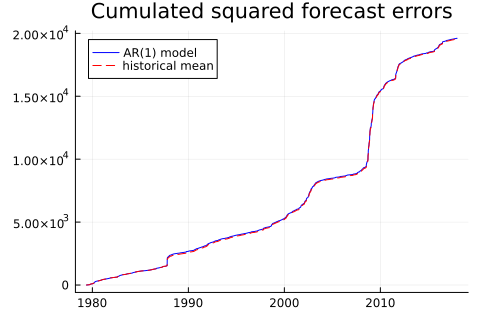

In [8]:
xTicksLoc = [Date(1980);Date(1990);Date(2000);Date(2010)]  
xTicksLab = Dates.format.(xTicksLoc,"Y")     #nice formatting of date axes

plot( dNb,[cumsum(ϵ.^2) cumsum(e.^2)],
      linecolor = [:blue :red],
      linestyle = [:solid :dash],
      label = ["AR(1) model" "historical mean"],
      legend = :topleft,
      xticks = (xTicksLoc,xTicksLab),
      title = "Cumulated squared forecast errors" )

## Mariano-Diebold and Clark-West Tests (extra)

The Mariano-Diebold and Clark-West tests compare the prediction errors of two models ($e$: benchmark; $\epsilon$: your model). Notice that the Mariano-Diebold test is not well suited for nested model (your model is an augmented version of the baseline model). Use the Clark-West in that case.

If $g_1 = e^2$ and $g_2=\epsilon^2$ are not autocorrelated, then the standard deviation of the sample average is Std$(g_i)/\sqrt{T}$. This assumption is used below.

In [9]:
function MDCW(e,ϵ)
      g = hcat(e.^2 - ϵ.^2,       #Mariano-Diebold
               2*e.*(e - ϵ))      #Clark&West
  return g
end

MDCW (generic function with 1 method)

In [10]:
g  = MDCW(e,ϵ)          #e,ϵ are from the recursive estimation (above)
Tg = size(g,1)

μ      = mean(g,dims=1)
Stdμ   = std(g,dims=1)/sqrt(Tg)
tstats = μ./Stdμ

printblue("t-stats of tests of difference in performance\n")
printmat(tstats';rowNames=["Mariano-Diebold","Clark-West"])

t-stats of tests of difference in performance

Mariano-Diebold    -0.430
Clark-West          0.814



# A Trading Strategy

This section implements a momentum strategy (buy past winners, short sell past losers), and rebalance daily. For simplicity, we disregard trading costs.

## Implementing the Strategy

1. Sort the 25 assets according to the lagged return, $R_{t-1}$.
2. (In the evening of) period  $t-1$  buy 1/5 of each of the 5 best assets based on the sort in point 1. Similarly, buy -1/5 (short-sell) each of the 5 worst assets. Collect these portfolio weights in a vector $w_{t}$.
3. In period  $t$ , the return on the portfolio is $R_{p,t}=w_{t}'R_{t}$.
4. Repeat for all periods

## A Remark on the Code

- `s = sortperm(R[t-1,:])` creates a vector of indices, where `s[1]` is the index of the asset with the lowest return in $t-1$, `s[2]` of the second lowest. Similarly, `s[end]` is the index of the asset with the highest return, while `s[end-1]` is for the second highest.
- The portfolio weights are not stored for use outside the loop. Only the strategy (portfolio) return is.

In [11]:
R = copy(R25)      #we recycly the `R` notation: it is now a Tx25 matrix
(T,n) = size(R)

Rₚ = fill(NaN,T)
for t = 2:T         #loop over periods, save portfolio returns
    #local s,w            #local/global is needed in script
    s                = sortperm(R[t-1,:])  #s[1] is the index of the worst asset
    w                = zeros(n)
    w[s[1:5]]       .= -1/5                #negative weights the worst 5
    w[s[end-4:end]] .= 1/5                 #positive weights for the best 5
    Rₚ[t]            = w'R[t,:]            #same as dot(w,[t,:])
end

Rₚ = Rₚ[2:end];                   #cut out t=1
println()

We calculate the mean (excess) return, its standard deviation and the Sharpe ratio. Annualising is done by assuming 250 trading days per year (means are multiplied by 250 and standard deviation by $\sqrt{250}$). Compare with the excess return on passively holding an equity market index.

In [12]:
μ = mean(Rₚ)                 #strategy
σ = std(Rₚ)

Rme = Rm - Rf                #market
μₘ  = mean(Rme[2:end])
σₘ  = std(Rme[2:end])

printblue("Annualised results:\n")
result  = [μ*250;σ*sqrt(250);μ/σ*sqrt(250)]
resultm = [μₘ*250;σₘ*sqrt(250);μₘ/σₘ*sqrt(250)]
printmat([result resultm],colNames=["Strategy","market"],rowNames=["mean","std","SR"])

Annualised results:

      Strategy    market
mean    16.134     8.307
std      9.871    16.770
SR       1.634     0.495



To cumulate the returns to a return index, use $(1+R_1)$, $(1+R_1)(1+R_2)$, etc. However, this does not work for excess returns, so convert them to net returns by adding the riskfree rate.

It is often more useful to show the logarithm of the return index. The slope can then be interpreted as a return.

In [13]:
Rbₚ = Rₚ + Rf[2:end]         #add Rf to make it a net return

Vₚ = cumprod(1 .+ Rbₚ/100)          #cumulate to return index ("value")
Vₘ = cumprod(1 .+ Rm[2:end]/100);  #notice /100 since percentage returns

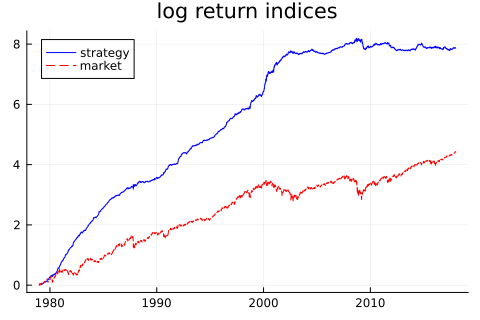

In [14]:
xTicksLoc = [Date(1980);Date(1990);Date(2000);Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

plot( dN[2:end],log.([Vₚ Vₘ]),
      linecolor = [:blue :red],
      linestyle = [:solid :dash],
      label = ["strategy" "market"],
      legend = :topleft,
      xticks = (xTicksLoc,xTicksLab),
      title = "log return indices" )